# Delaunay Triangulation in 3D

a)

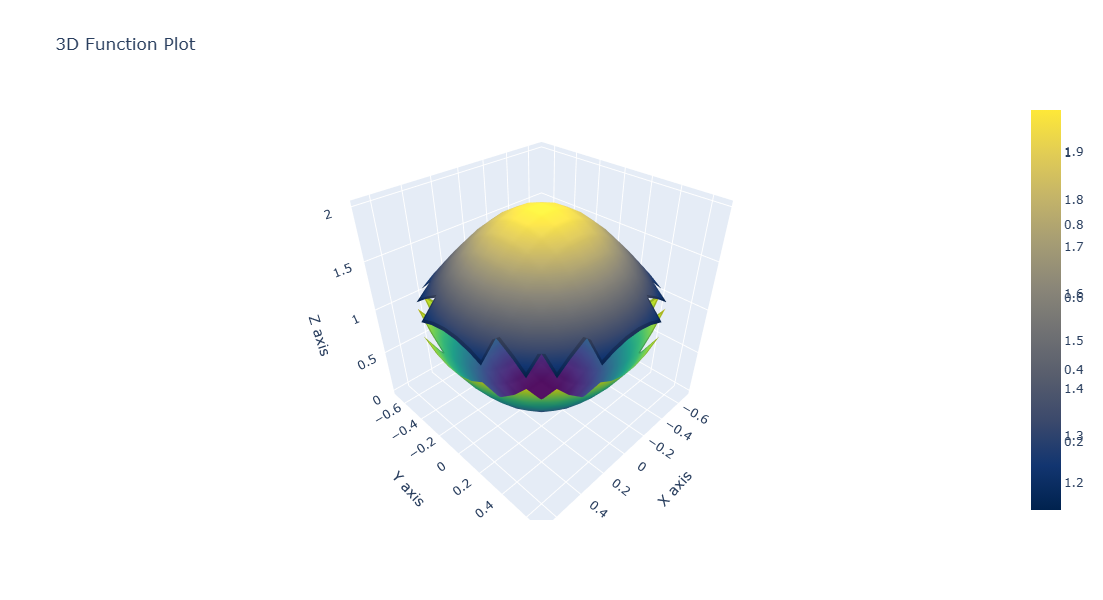

In [51]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def surface1(x, y):
    return 2 * x**2 + 2 * y**2   #lower surface

def surface2(x, y):
    return 2 * np.exp(-x**2 - y**2)    #upper surface

res = 20
Xarr, Yarr = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))

lower = surface1(Xarr, Yarr) #lower face of the enclosed surface
upper = surface2(Xarr, Yarr) #upper face of the enclosed surface

#We also need to smoothly join the boundary later
boundary_mask = np.isclose(lower, upper, atol=0.05)  # Points where surfaces meet
X_boundary = Xarr[boundary_mask]
Y_boundary = Yarr[boundary_mask]
Z_boundary = lower[boundary_mask]  # or upper, they should be equal

# Mask points where the condition is not met, we must be on the closed surface, where surface1 is below surface2
mask = (lower <= upper)
X_arrm = np.where(mask, Xarr, None)
Y_arrm = np.where(mask, Yarr, None)
Z1 = np.where(mask, lower, None)      
Z2 = np.where(mask, upper, None)



# Create a 3D surface plot
fig = go.Figure()

# Add both surfaces to the figure
fig.add_trace(go.Surface(z=Z1, x=Xarr, y=Yarr, colorscale='Viridis', name="Surface 1"))
fig.add_trace(go.Surface(z=Z2, x=Xarr, y=Yarr, colorscale='Cividis', name="Surface 2"))

fig.update_layout(title="3D Function Plot", autosize=False, width=600, height=600, scene=dict(
        xaxis_title="X axis",
        yaxis_title="Y axis",
        zaxis_title="Z axis",
    ),
)

# Show the plot
fig.show()


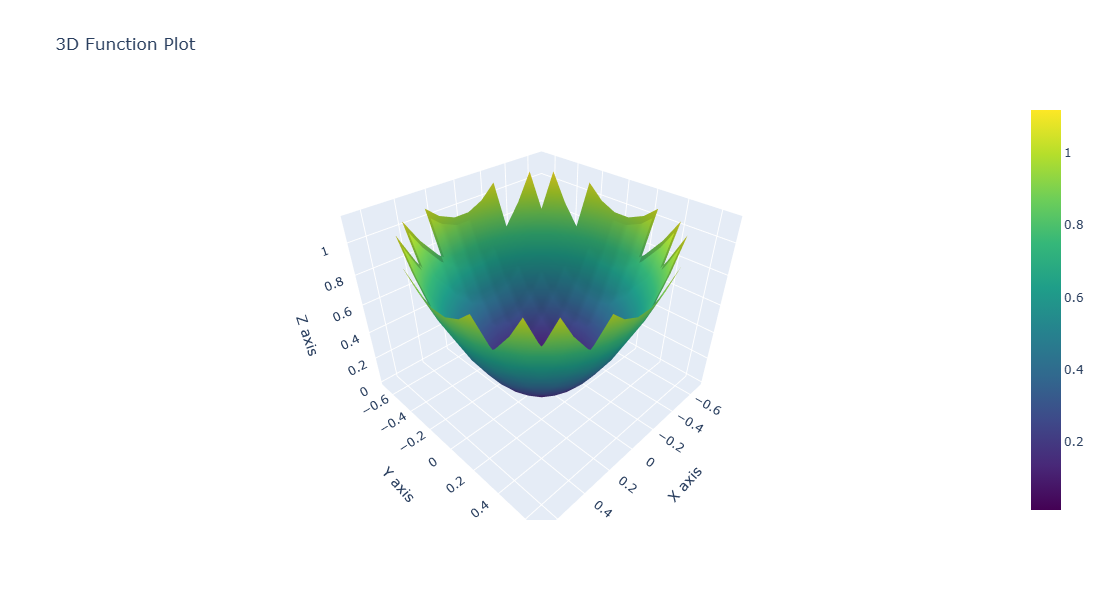

In [53]:

# Zboth = np.concatenate((Z1,Z2), axis=0)
# Xarrboth = np.concatenate((X_arrm, X_arrm), axis=0)
# Yarrboth = np.concatenate((Y_arrm, Y_arrm), axis=0)           for now I just want one surface

Zboth = Z1
Xarrboth = X_arrm
Yarrboth = Y_arrm

fig1 = go.Figure()

# Add both surfaces to the figure
fig1.add_trace(go.Surface(z=Zboth, x=Xarrboth, y=Yarrboth, colorscale='Viridis', name="Closed surface"))
fig1.update_layout(title="3D Function Plot", autosize=False, width=600, height=600, scene=dict(
        xaxis_title="X axis",
        yaxis_title="Y axis",
        zaxis_title="Z axis",
    ),
)

# Show the plot
fig1.show()

[[-0.47368421 -0.57894737  1.11911357]
 [ 0.47368421 -0.57894737  1.11911357]
 [-0.57894737 -0.47368421  1.11911357]
 [ 0.57894737 -0.47368421  1.11911357]
 [-0.57894737  0.47368421  1.11911357]
 [ 0.57894737  0.47368421  1.11911357]
 [-0.47368421  0.57894737  1.11911357]
 [ 0.47368421  0.57894737  1.11911357]]


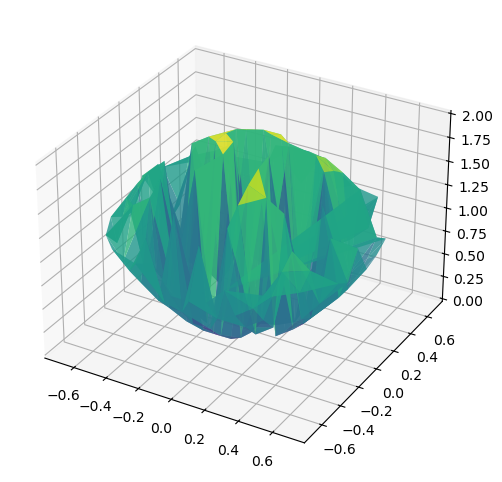

In [55]:
Zboth = np.concatenate((Z1,Z2), axis=0)
Xarrboth = np.concatenate((X_arrm, X_arrm), axis=0)
Yarrboth = np.concatenate((Y_arrm, Y_arrm), axis=0)

# Mask where invalid points exist
valid_mask = Xarrboth != None
X = Xarrboth[valid_mask]
Y = Yarrboth[valid_mask]
Z = Zboth[valid_mask]

# Combine into points array
all_points = np.vstack((X, Y, Z)).T  # Ensure all valid points are included
boundary_points = np.vstack((X_boundary, Y_boundary, Z_boundary)).T  # Boundary connection
print(boundary_points)
combined_points = np.vstack((all_points, boundary_points))

points = points.astype(float)  #for some reason points had dtype object, (reason why I had to use None instead of np.nan)

# Perform Delaunay triangulation, ensuring we use boundary points
tri = Delaunay(combined_points[:, :2]) 


# Plot the triangulated surface in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


# Use plot_trisurf to create the surface
ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles=tri.simplices, cmap='viridis', alpha=0.8)

# Show the plot
plt.show()



# b)

At this point I realized I needed to do some more work to properly join the two surfaces. Since our current method is doing the triangulation in 2D, and then lifting the points in z, I can't just throw together all the points and expect that to work.
I'll join together the two sets of points by finding the boundary points. Then I'll use the fact that each edge at the boundary is shared by two triangles

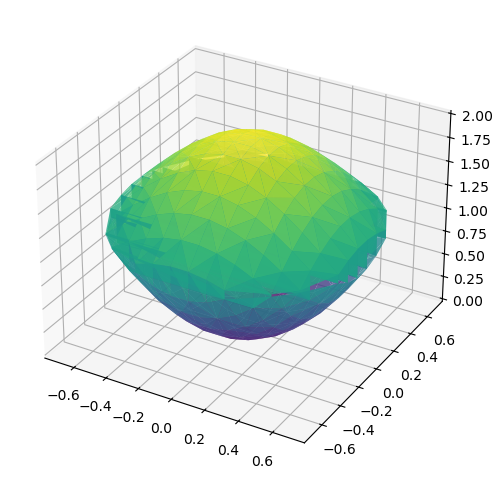

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define the surfaces
def surface1(x, y):
    return 2 * x**2 + 2 * y**2   # Lower surface

def surface2(x, y):
    return 2 * np.exp(-x**2 - y**2)  # Upper surface

# Define resolution and mesh grid
res = 20
Xarr, Yarr = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))

# Compute surface values
lower = surface1(Xarr, Yarr)
upper = surface2(Xarr, Yarr)

# Mask to ensure lower surface is beneath upper
mask = (lower <= upper)

# Apply mask
X_arrm = Xarr[mask]
Y_arrm = Yarr[mask]
Z1 = lower[mask]  # Lower surface
Z2 = upper[mask]  # Upper surface

# Identify boundary points: locations where the transition occurs
boundary_mask = mask & (
    (np.roll(mask, 1, axis=0) == False) | 
    (np.roll(mask, -1, axis=0) == False) | 
    (np.roll(mask, 1, axis=1) == False) | 
    (np.roll(mask, -1, axis=1) == False)
)

X_boundary = Xarr[boundary_mask]
Y_boundary = Yarr[boundary_mask]
Z_boundary_lower = lower[boundary_mask]
Z_boundary_upper = upper[boundary_mask]

# Combine lower and upper surfaces into separate sets
points_lower = np.column_stack((X_arrm, Y_arrm, Z1))
points_upper = np.column_stack((X_arrm, Y_arrm, Z2))

# Perform Delaunay triangulation separately for lower and upper surfaces
tri_lower = Delaunay(points_lower[:, :2])  # 2D triangulation on XY plane
tri_upper = Delaunay(points_upper[:, :2])  # Same for upper surface

# Merge the two sets of points
points_combined = np.vstack((points_lower, points_upper))
num_lower = len(points_lower)  # Number of vertices in lower surface

# Create connectivity for the sidewalls (joining lower and upper boundaries)
boundary_triangles = []
for i in range(len(X_boundary)):
    lower_index = np.where((points_lower[:, 0] == X_boundary[i]) & (points_lower[:, 1] == Y_boundary[i]))[0][0]
    upper_index = np.where((points_upper[:, 0] == X_boundary[i]) & (points_upper[:, 1] == Y_boundary[i]))[0][0] + num_lower  # Offset for upper surface

    # Create two triangles per vertical strip
    if i < len(X_boundary) - 1:
        lower_next_index = np.where((points_lower[:, 0] == X_boundary[i + 1]) & (points_lower[:, 1] == Y_boundary[i + 1]))[0][0]
        upper_next_index = np.where((points_upper[:, 0] == X_boundary[i + 1]) & (points_upper[:, 1] == Y_boundary[i + 1]))[0][0] + num_lower

        boundary_triangles.append([lower_index, lower_next_index, upper_index])
        boundary_triangles.append([upper_index, lower_next_index, upper_next_index])

# Combine all triangles
all_triangles = np.vstack((tri_lower.simplices, tri_upper.simplices + num_lower, boundary_triangles))

# Plot the triangulated surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(points_combined[:, 0], points_combined[:, 1], points_combined[:, 2], triangles=all_triangles, cmap='viridis', alpha=0.8)

plt.show()


# c) and d)

Now creating a volume mesh first. This should be simpler since we don't have to deal with joining up 2D meshes.

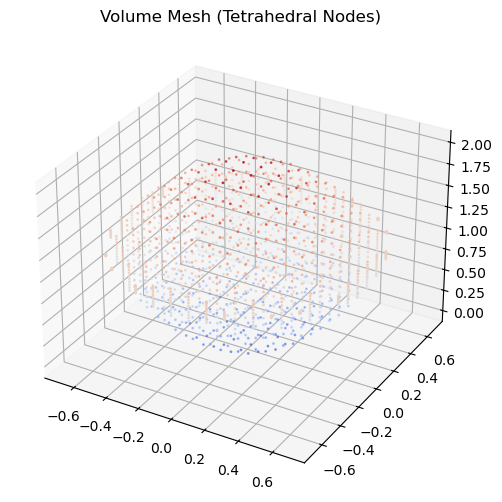

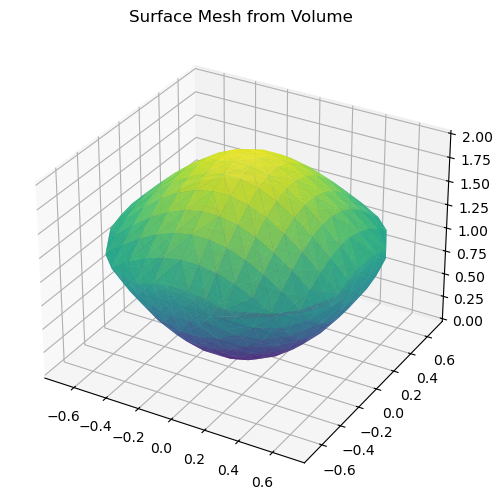

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define the surfaces
def surface1(x, y):
    return 2 * x**2 + 2 * y**2   # Lower surface

def surface2(x, y):
    return 2 * np.exp(-x**2 - y**2)  # Upper surface

# Define resolution and mesh grid
res = 20  # Reduce for better visualization
Xarr, Yarr = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))

# Compute surface values
lower = surface1(Xarr, Yarr)
upper = surface2(Xarr, Yarr)

# Mask valid points
mask = lower <= upper
X_arrm = Xarr[mask]
Y_arrm = Yarr[mask]
Z1 = lower[mask]  # Lower surface   
Z2 = upper[mask]  # Upper surface

# Create volume points by interpolating between lower and upper surfaces
num_layers = 10  # Number of layers in the volume
Z_layers = np.linspace(Z1, Z2, num_layers)  # Interpolated Z values

# Stack all points in 3D space
X_vol = np.tile(X_arrm, num_layers)
Y_vol = np.tile(Y_arrm, num_layers)
Z_vol = Z_layers.flatten()

points_vol = np.column_stack((X_vol, Y_vol, Z_vol))

# Perform Delaunay triangulation in 3D (tetrahedral mesh)
tetra_mesh = Delaunay(points_vol)

# **(c) Visualize the volume mesh (plot only a subset for clarity)**
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_vol[:, 0], points_vol[:, 1], points_vol[:, 2], s=1, c=Z_vol, cmap="coolwarm")

plt.title("Volume Mesh (Tetrahedral Nodes)")
plt.show()

# **(d) Extract Surface Mesh from Tetrahedral Volume**
faces = []
for simplex in tetra_mesh.simplices:
    faces.extend([
        (simplex[0], simplex[1], simplex[2]),
        (simplex[0], simplex[1], simplex[3]),
        (simplex[0], simplex[2], simplex[3]),
        (simplex[1], simplex[2], simplex[3])
    ])

# Count occurrences of each face
from collections import Counter
face_counts = Counter(frozenset(face) for face in faces)

# Extract faces that appear only once (boundary)
surface_faces = [list(face) for face in face_counts if face_counts[face] == 1]

# Convert faces to numpy array
surface_faces = np.array(surface_faces)

# **Visualize the surface mesh**
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(points_vol[:, 0], points_vol[:, 1], points_vol[:, 2], triangles=surface_faces, cmap="viridis", alpha=0.8)

plt.title("Surface Mesh from Volume")
plt.show()

 # d) 
 I just completed parts c and d above. To answer part d), each triangle will be shared by two tetrahedron, except if it is at the surface. We actually use this fact to determine which triangular faces should be included in the surface mesh.